# Project 2: Classification

Load all the packages you are going to use.

In [1]:
#Calculations and visualizations

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Modeling

In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

In [5]:
#Feature engineering

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

# to visualize the column transformer and pipeline
set_config(display='diagram')

# 1. Define project goal

The Titanic passenger list can be used for an exercise classification task: Given the data of a new passenger, we want to predict whether they will survive the disaster.

# 2. Get the data

Read the file train.csv into Python and print a few rows.

In [7]:
df = pd.read_csv("train.csv", index_col = 0)

In [8]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df.shape

(891, 11)

In [10]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
df.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            882, 883, 884, 885, 886, 887, 888, 889, 890, 891],
           dtype='int64', name='PassengerId', length=891)

# 3. EDA

#### Missing data

In [149]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 115.8+ KB


<AxesSubplot:ylabel='PassengerId'>

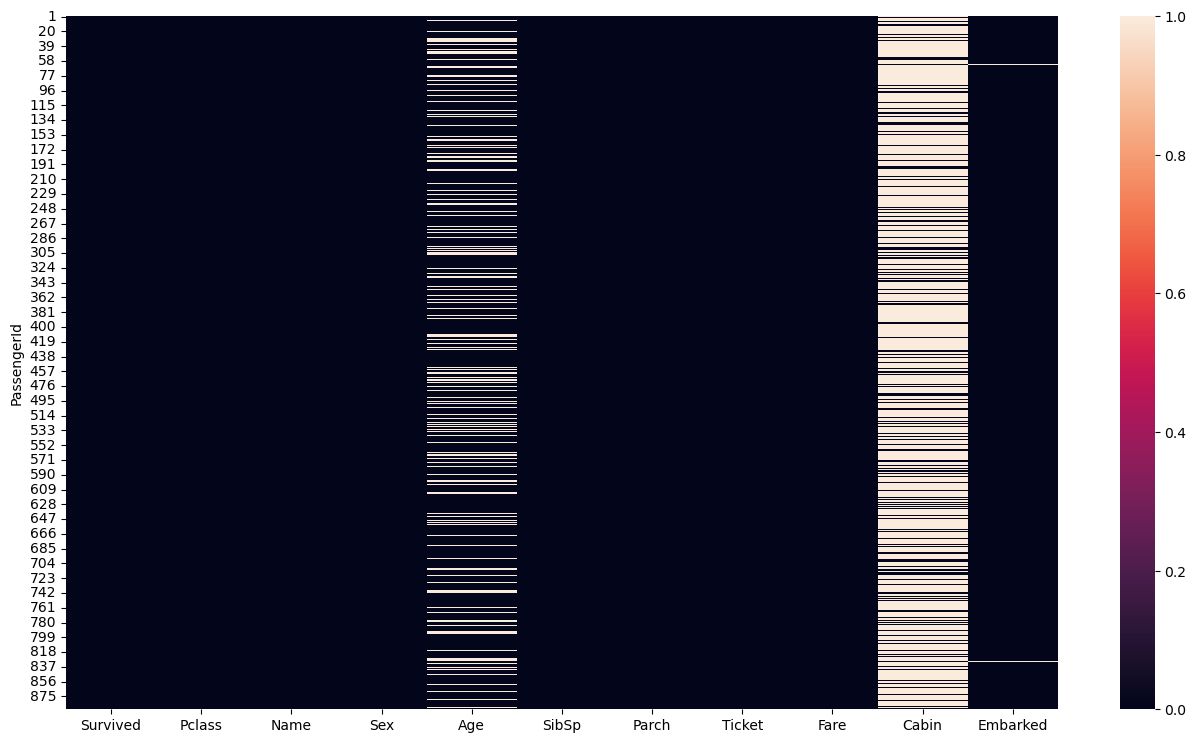

In [153]:
plt.figure(figsize = (16, 9))
sns.heatmap(df.isnull())

"Cabin" feature has 687 missing values out of the 890. I decided it is safer to discard it than try to do any engineering with it.

I assume that "Embarked" categorical feature would not contribute much to the model, so I will drop it. Same for the Ticket and Name.

#### Calculate the number of surviving/non-surviving passengers and display it as a bar plot.

In [69]:
df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [157]:
df2 = df.groupby(["Survived"]).count()
df2

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,
0,549,549,549,424,549,549,549,549,68,549
1,342,342,342,290,342,342,342,342,136,340


<AxesSubplot:ylabel='Survived'>

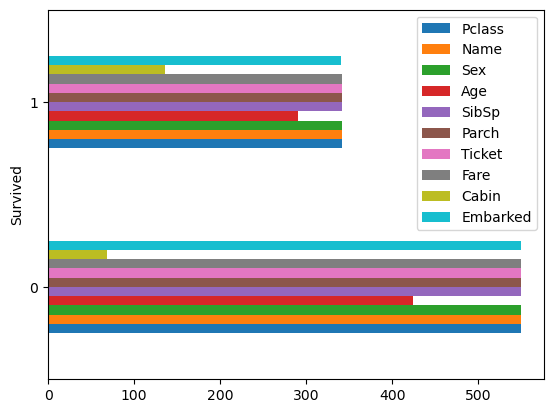

In [161]:
#plt.figure(figsize = (16, 9))
df2.plot.barh()

Let's try to investigate further the shape of the data, by checking the correlation between the numerical features.

Then it would be, hopefully, safer to decide on which numeric features to keep for the model.

#### Calculate and plot correlation to check the relationships between the numerical features.

In [163]:
df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


<AxesSubplot:>

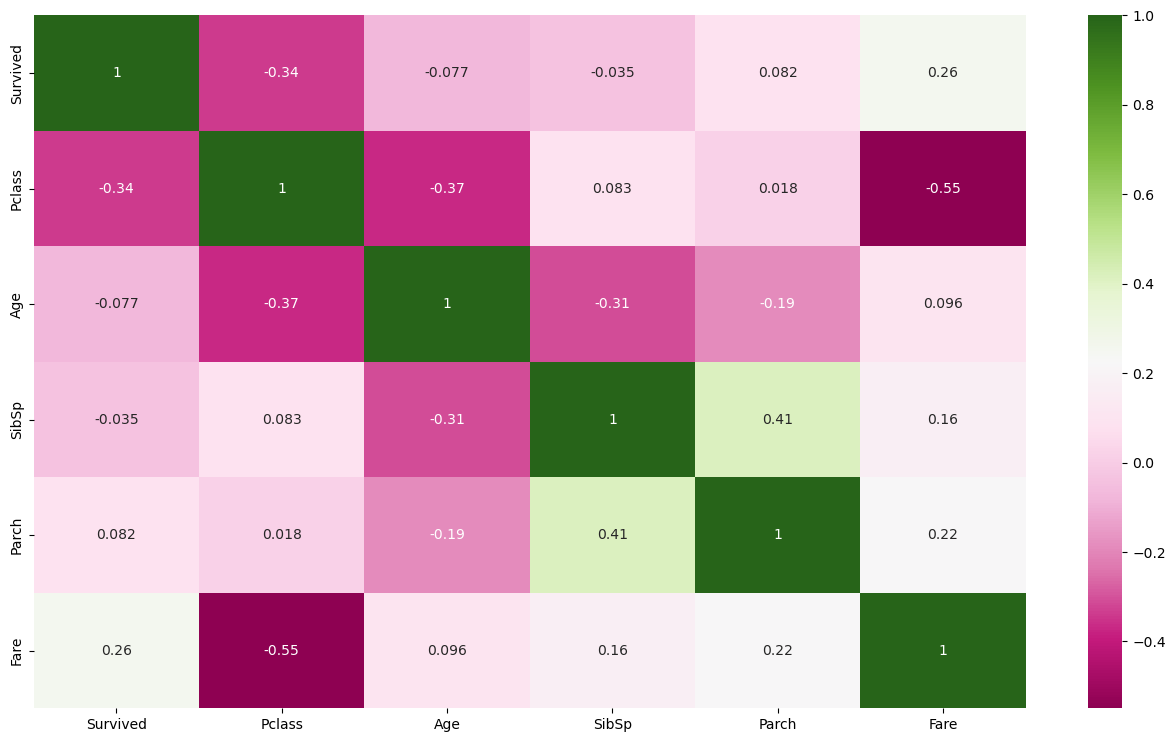

In [165]:
plt.figure(figsize=(16, 9))
sns.heatmap(df.corr(), cmap = "PiYG", annot = True)

The numerical features which are shown to have the strongest correlation with "Survived" are "Pclass" and "Fare".

#### Take a closer look on the features Pclass, Sex, Parch, SibSp, Fare and Age.

First of all, let's define the survived and non_survived dataframes, in order to use them in the upcoming exploratory data analyses.

In [166]:
survived = df[df["Survived"] == 1]

In [167]:
non_survived = df[df["Survived"] == 0]

##### Pclass / Sex

Get a first idea of the feature.

In [168]:
df["Pclass"].unique()

array([3, 1, 2])

<AxesSubplot:xlabel='Pclass'>

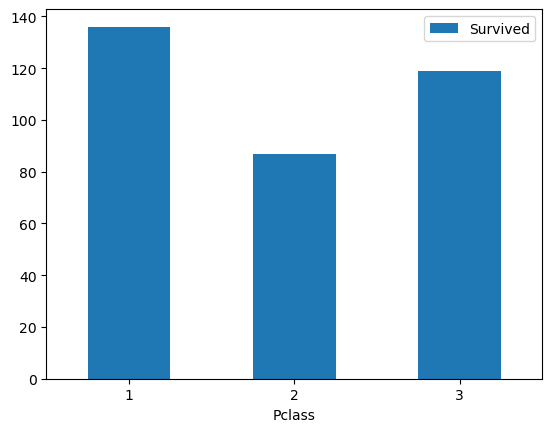

In [132]:
survived[["Pclass", "Survived"]].groupby(["Pclass"]).count().plot.bar(rot = 0)

<AxesSubplot:xlabel='Pclass'>

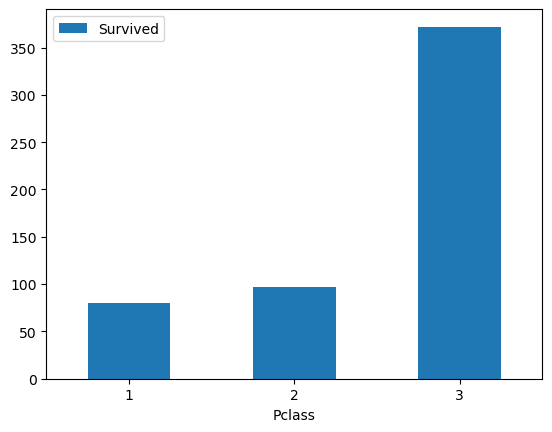

In [133]:
non_survived[["Pclass", "Survived"]].groupby(["Pclass"]).count().plot.bar(rot = 0)

###### Create a bar plot with separate bars for male/female passengers and 1st/2nd/3rd class passengers.

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

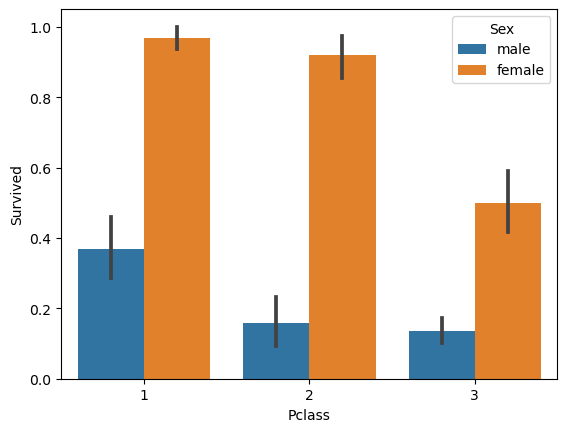

In [173]:
sns.barplot(data = df, x = "Pclass", y = "Survived", hue = "Sex")

It seems that "Sex" feature is important to be included for the model. Let's plot is towards "Survived".

<AxesSubplot:xlabel='Sex', ylabel='count'>

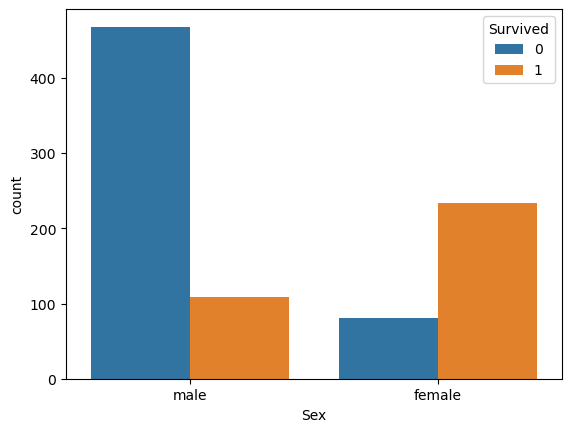

In [172]:
sns.countplot(data = df, x = "Sex", hue = "Survived")

Check its correlation to "Pclass", "Fare" and "Survived", by creating and plotting a table which counts the number of surviving/dead passengers separately for 1st/2nd/3rd class and male/female.

In [121]:
df[["Fare", "Sex", "Pclass", "Survived"]].groupby(["Pclass", "Sex", "Survived"]).count()

Fare
Pclass Sex    Survived      
1      female 0            3
              1           91
       male   0           77
              1           45
2      female 0            6
              1           70
       male   0           91
              1           17
3      female 0           72
              1           72
       male   0          300
              1           47

<AxesSubplot:xlabel='Pclass,Sex,Survived'>

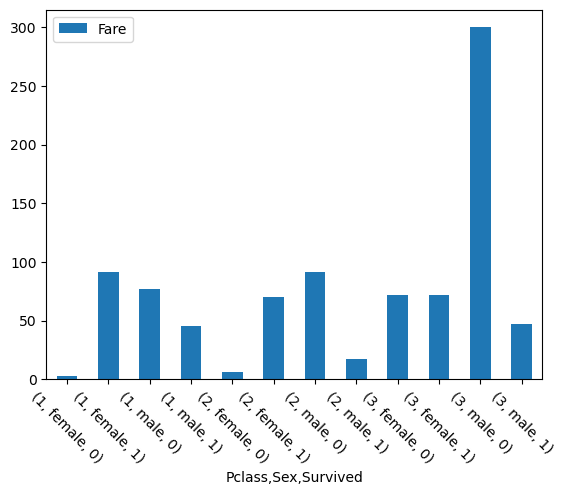

In [141]:
df[["Fare", "Sex", "Pclass", "Survived"]].groupby(["Pclass", "Sex", "Survived"]).count().plot.bar(rot = -45)

"Sex" feature is going to be kept for the model.

##### Parch

Get an idea of the feature.

In [126]:
df["Parch"].unique()

array([0, 1, 2, 5, 3, 4, 6])

<AxesSubplot:xlabel='Parch'>

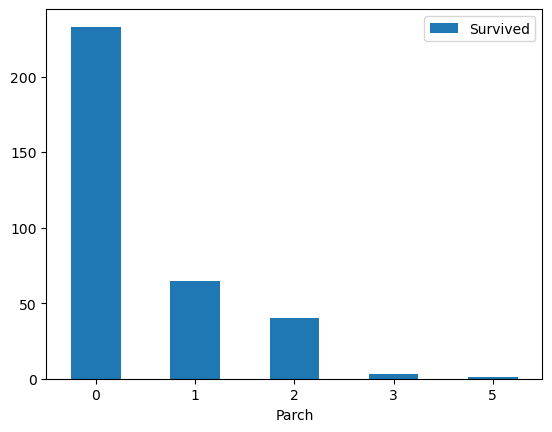

In [134]:
survived[["Parch", "Survived"]].groupby(["Parch"]).count().plot.bar(rot = 0)

<AxesSubplot:xlabel='Parch'>

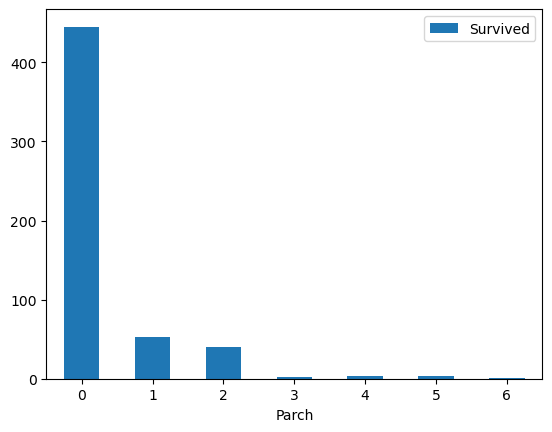

In [135]:
non_survived[["Parch", "Survived"]].groupby(["Parch"]).count().plot.bar(rot = 0)

##### SibSp

Get an idea of the feature.

In [136]:
df["SibSp"].unique()

array([1, 0, 3, 4, 2, 5, 8])

<AxesSubplot:xlabel='SibSp'>

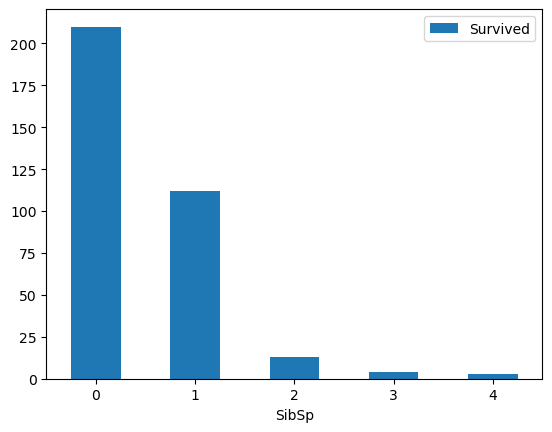

In [137]:
survived[["SibSp", "Survived"]].groupby(["SibSp"]).count().plot.bar(rot = 0)

<AxesSubplot:xlabel='SibSp'>

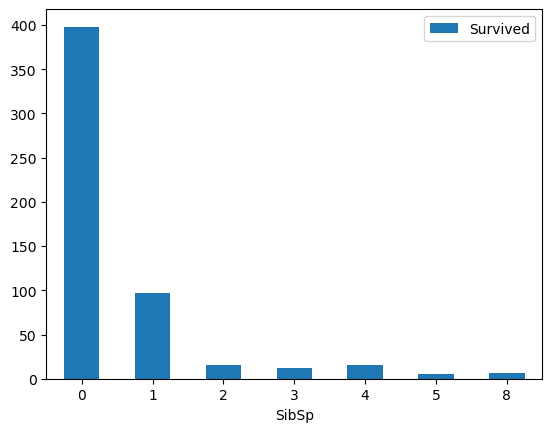

In [138]:
non_survived[["SibSp", "Survived"]].groupby(["SibSp"]).count().plot.bar(rot = 0)

##### Fare

Take a look at the range and median of the feature.

In [64]:
df.agg({"Fare" : ["max", "min"]})

,Fare
max,512.3292
min,0.0000


In [147]:
df["Fare"].median()

14.4542

In [116]:
survived["Fare"].median()

26.0

In [117]:
non_survived["Fare"].median()

10.5

In [114]:
df[df["Fare"] == df["Fare"].max()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


In [115]:
df[df["Fare"] == df["Fare"].min()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S


Create overlapping histograms for the fare.

/tmp/ipykernel_130261/3263231038.py:6: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([hist1_f, hist0_f], labels =["Survived", "Did not survive"])


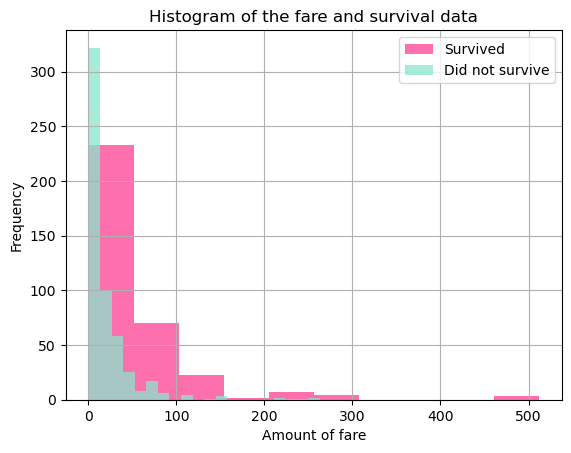

In [140]:
hist1_f = df[df["Survived"] == 1]["Fare"].hist(bins = 10, facecolor= '#fd3f92',alpha=0.75,histtype='bar')
hist0_f = df[df["Survived"] == 0]["Fare"].hist(bins= 20, facecolor= '#8ae6cc',alpha= 0.75,histtype='bar')
plt.title('Histogram of the fare and survival data')
plt.xlabel('Amount of fare')
plt.ylabel('Frequency')
plt.legend([hist1_f, hist0_f], labels =["Survived", "Did not survive"])

##### Age

Take a look at the range and mean of the feature.

In [142]:
df.agg({"Age" : ["max", "min"]})

,Age
max,80.00
min,0.42


In [148]:
df["Age"].mean()

29.69911764705882

In [36]:
survived["Age"].mean()

28.343689655172415

In [37]:
non_survived["Age"].mean()

30.62617924528302

Create overlapping histograms for the age.

/tmp/ipykernel_130261/1008945791.py:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([hist1_a, hist0_a], labels =["Did not Survived", "Survived"])


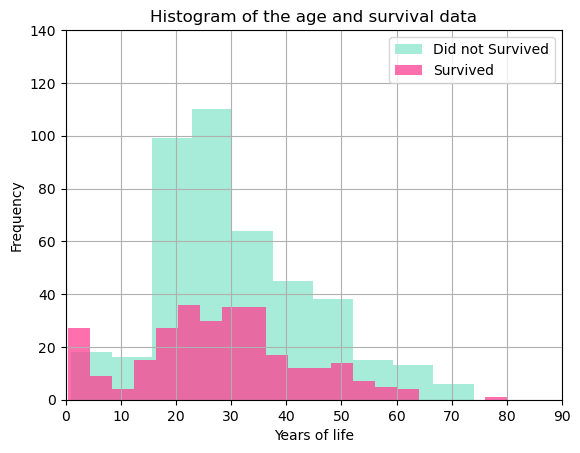

In [174]:
hist0_a = df[df["Survived"] == 0]["Age"].hist(bins= 10, facecolor= '#8ae6cc', alpha= 0.75, histtype='bar')
hist1_a = df[df["Survived"] == 1]["Age"].hist(bins = 20, facecolor= '#fd3f92', alpha=0.75, histtype='bar')
plt.title('Histogram of the age and survival data')
plt.xlabel('Years of life')
plt.ylabel('Frequency')
plt.axis([0.0, 90.0, 0.0, 140.0])
plt.legend([hist1_a, hist0_a], labels =["Did not Survived", "Survived"])

Regarding the "Parch" and "SibSp" features, I would keep the second one as the barplots showed an interesting split towards survival.

I will also keep "Age" as the histogram above implies a higher probabiblity to not survive in a range of ca. 18  to 53.

# 4. Train-test split 

Define X and y.

In [12]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
X = df.drop(["Survived", "Name", "Parch", "Ticket", "Cabin", "Embarked"], axis = 1)

In [14]:
X

,Pclass,Sex,Age,SibSp,Fare
PassengerId,,,,,
1,3,male,22.0,1,7.2500
2,1,female,38.0,1,71.2833
3,3,female,26.0,0,7.9250
4,1,female,35.0,1,53.1000
5,3,male,35.0,0,8.0500
...,...,...,...,...,...
887,2,male,27.0,0,13.0000
888,1,female,19.0,0,30.0000
889,3,female,NaN,1,23.4500


In [15]:
type(X)

pandas.core.frame.DataFrame

In [16]:
y = df["Survived"]

In [17]:
y

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

In [18]:
type(y)

pandas.core.series.Series

Split.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 5), (179, 5), (712,), (179,))

In [21]:
X_train, X_test

(             Pclass     Sex   Age  SibSp      Fare
 PassengerId                                       
 332               1    male  45.5      0   28.5000
 734               2    male  23.0      0   13.0000
 383               3    male  32.0      0    7.9250
 705               3    male  26.0      1    7.8542
 814               3  female   6.0      4   31.2750
 ...             ...     ...   ...    ...       ...
 107               3  female  21.0      0    7.6500
 271               1    male   NaN      0   31.0000
 861               3    male  41.0      2   14.1083
 436               1  female  14.0      1  120.0000
 103               1    male  21.0      0   77.2875
 
 [712 rows x 5 columns],
              Pclass     Sex   Age  SibSp     Fare
 PassengerId                                      
 710               3    male   NaN      1  15.2458
 440               2    male  31.0      0  10.5000
 841               3    male  20.0      0   7.9250
 721               2  female   6.0      0 

In [22]:
y_train, y_test

(PassengerId
 332    0
 734    0
 383    0
 705    0
 814    0
       ..
 107    1
 271    0
 861    0
 436    1
 103    0
 Name: Survived, Length: 712, dtype: int64,
 PassengerId
 710    1
 440    0
 841    0
 721    1
 40     1
       ..
 434    0
 774    0
 26     1
 85     1
 11     1
 Name: Survived, Length: 179, dtype: int64)

# 5. Feature Engineering

In [23]:
X_train.head()

,Pclass,Sex,Age,SibSp,Fare
PassengerId,,,,,
332,1,male,45.5,0,28.5000
734,2,male,23.0,0,13.0000
383,3,male,32.0,0,7.9250
705,3,male,26.0,1,7.8542
814,3,female,6.0,4,31.2750


Chech for missing values in the train datasets.

In [24]:
X_train.isnull().sum()

Pclass      0
Sex         0
Age       140
SibSp       0
Fare        0
dtype: int64

In [25]:
y_train.isnull().sum()

0

"Age" feature needs to be imputed. It would be useful to do some scaling to this feature.

In [26]:
X_train["Pclass"].unique()

array([1, 2, 3])

In [27]:
X_train["Sex"].unique()

array(['male', 'female'], dtype=object)

In [28]:
X_train["SibSp"].unique()

array([0, 1, 4, 3, 2, 8, 5])

"Pclass" feature needs to get an one hot encoding and a drop of the first column to avoid multilinearity. The same will be done for the "Sex" and "SibSp" features.

"Fare" feature needs scaling.

Let's try to do the engineering mentioned above by introducing first a pipeline for "Age" and subsequently a column transformer for all the features.

In [29]:
age_pipeline = Pipeline([("imputer", SimpleImputer(strategy = "mean")), 
                        ("scaler", RobustScaler())])

In [30]:
column_transformer = ColumnTransformer([
    ("age_pipeline", age_pipeline, ["Age"]),
    ("ohe", OneHotEncoder(drop = "first"), ["Pclass", "Sex", "SibSp"]),
    ("scaler", RobustScaler(), ["Fare"])
])

In [31]:
column_transformer

ColumnTransformer(transformers=[('age_pipeline',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', RobustScaler())]),
                                 ['Age']),
                                ('ohe', OneHotEncoder(drop='first'),
                                 ['Pclass', 'Sex', 'SibSp']),
                                ('scaler', RobustScaler(), ['Fare'])])

In [32]:
# fit and transform the ColumnTransformer() ONLY using train data
X_train_fe = column_transformer.fit_transform(X_train, y_train)

In [33]:
# use the fitted transformer on X_test
X_test_fe = column_transformer.transform(X_test)

Check if the feature engineering applied to train and test datasets.

In [34]:
X_train_fe.shape, X_train.shape, y_train.shape

((712, 11), (712, 5), (712,))

In [35]:
X_test_fe.shape, X_test.shape, y_test.shape

((179, 11), (179, 5), (179,))

Assign to X_train_fe to a dataframe of X_train_fe.

In [36]:
X_train_fe = pd.DataFrame(X_train_fe)

In [37]:
X_train_fe.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.230858,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.622184
1,-0.499911,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.064416
2,0.192396,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.289223
3,-0.269142,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.292359
4,-1.807604,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.745107


In [38]:
X_train_fe.shape

(712, 11)

Assign to X_test_fe to a dataframe of X_test_fe.

In [39]:
X_test_fe = pd.DataFrame(X_test_fe)

In [40]:
X_test_fe.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.035065
1,0.115473,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.175158
2,-0.730680,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.289223
3,-1.807604,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.821519
4,-1.192219,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.142303


In [41]:
X_test_fe.shape

(179, 11)

# 6. Train model

#### Build a baseline model.

In [42]:
m = DummyClassifier(strategy = "most_frequent")

In [43]:
m

DummyClassifier(strategy='most_frequent')

In [44]:
m.fit(X_train_fe, y_train)

DummyClassifier(strategy='most_frequent')

In [45]:
m.classes_

array([0, 1])

In [46]:
ypred = m.predict(X_train_fe)

In [47]:
ypred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [48]:
m.predict(X_test_fe)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [49]:
m.score(X_train_fe, y_train)

0.6235955056179775

In [50]:
m.score(X_test_fe, y_test)

0.5865921787709497